In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils.training import *
from src.scripts.load_and_save import * 

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1*

In [4]:
affinity = "IC50 (nM)"
data = load_data_direct(affinity=affinity)

/mloscratch/homes/sallinen/embeddings/src/scripts/load_and_save.py:18: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, sep='\t', on_bad_lines='skip', usecols=["Ligand SMILES",


In [4]:
unique_ligands = data["ligand"].unique()
print(f"Unique ligands: {len(unique_ligands)}")
print(f"Proportion of data: {len(unique_ligands) / len(data)}")

Unique ligands: 1269428
Proportion of data: 0.43360571715690177


# Step 2

In [ ]:
common_grams = parallel_ngrams(data)
ligands_atoms = atom_set(data["ligand"])
total_vocabulary = build_vocab(common_grams, ligands_atoms)

In [ ]:
from tokenizers.pre_tokenizers import Split
from tokenizers import Regex

escaped_tokens = [re.escape(token) for token in total_vocabulary]
pattern = '|'.join(sorted(escaped_tokens, key=len, reverse=True))
preTokenizer = Split(Regex(pattern), behavior='isolated')
preTokenizer.pre_tokenize_str('CC(=O)O')

In [ ]:
tokenizer = generate_tokenizer(data, preTokenizer)

In [ ]:
tokenizer.save_pretrained("models/tokenizer")

# STEP 2*

In [5]:
# Load the tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("models/tokenizer")

Maximum length: 2115


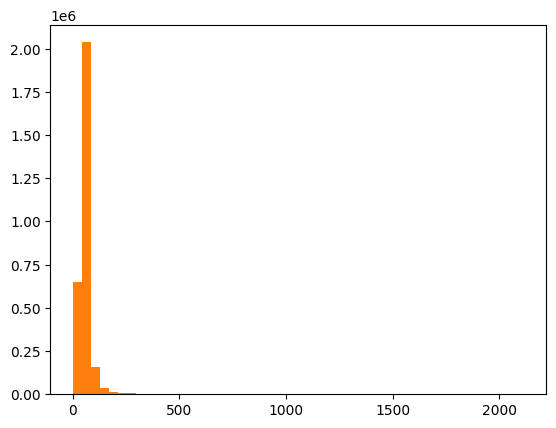

In [10]:
import matplotlib.pyplot as plt

maximum_length = max([len(smiles) for smiles in data["ligand"]])
print(f"Maximum length: {maximum_length}")



plt.hist([len(smiles) for smiles in data["ligand"] if len(smiles) < 1024], bins=50)
plt.hist([len(smiles) for smiles in data["ligand"]], bins=50)

plt.show()

In [11]:
tokenizer.decode(tokenizer.encode("CC(=O)O", "CCcc", add_special_tokens=True))


'[CLS] CC (=O) O [SEP] CC cc [SEP]'

In [6]:

model, data_collator = generate_model(tokenizer, max_in_size=512, multiplier=1)
#pretty print the number
print(f"Number of parameters: {model.num_parameters()}")

The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


Vocab size: 100
Number of parameters: 706816


In [8]:
tokenized_dataset = tokenize_smiles_dataset(data, tokenizer, model.config.max_position_embeddings)
tokenized_dataset

Saving the dataset (2/2 shards): 100%|██████████| 1269428/1269428 [00:01<00:00, 974296.37 examples/s] 


Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1269428
})

In [9]:
print(len(tokenized_dataset))
print(len(data))

1269428
2927609


# Step 3*

In [12]:
tokenized_dataset = Dataset.load_from_disk("data/tokenized_dataset")
tokenized_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1269428
})

In [16]:
# clear cuda cache and gc
import torch
import gc
torch.cuda.empty_cache()
gc.collect()
model = model.to("cuda")

#Drop label column
tokenized_dataset = tokenized_dataset.remove_columns("labels")

In [ ]:
model, tokenizer, logs = train_fundation(model, tokenizer, data_collator, tokenized_dataset)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


Step,Training Loss
10,39.641100
20,4.958600
30,2.406100
40,1.951700
50,1.771000
60,1.656800
70,1.607400
80,1.553300
90,1.523700
100,1.508000


In [ ]:
# the affinity column contians nan values and may contain other values that are not numbers. Clean the data
print(data.isna().sum() / len(data)) 
data_filtered = data.dropna(subset=["affinity"])
print(data_filtered.isna().sum() / len(data_filtered)) 
data_filtered = data_filtered.dropna(subset=["target"])
print(data_filtered.isna().sum() / len(data_filtered)) 

In [ ]:
dataset = Dataset.from_list([{"text": ligand} for ligand in ligands])
tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"], batch_size=1000)

In [ ]:
# save tokenised dataset
tokenized_dataset.save_to_disk("data/tokenized_dataset")
# save tokenizer
fast_tokenizer.save_pretrained("data/tokenizer")

In [ ]:

fast_tokenizer = AutoTokenizer.from_pretrained("data/tokenizer")

In [3]:
# Test the model
from transformers import MambaForCausalLM, AutoTokenizer

# Load the model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MambaForCausalLM.from_pretrained("./mamba-smiles/checkpoint-2000").to(device)
tokenizer = AutoTokenizer.from_pretrained("./mamba-smiles/checkpoint-2000", device=device)

The fast path is not available because on of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the naive implementation. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d


In [5]:
from transformers import pipeline

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Generate some SMILES
smiles = generator("CC(=O)O", max_length=512, 
                   temperature=0.5, 
                   num_return_sequences=5,
                   num_beams=5,  # Use beam search to generate multiple sequences
                   top_k=50, top_p=0.95)

smiles[0]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


{'generated_text': 'CC(=O)O [C@H] 2'}

In [6]:
dataset_ic = Dataset.load_from_disk("data/ic50_dataset")